**<big><center>Constructing Optimized Molecular Pairs with SME</center></big>** <br />
    Here, we'll briefly explain how to construct optimized molecular pairs using the Substructure Mask Explanation (SME) approach.<br />
**1. Detect the substructure for modification.**<br />
    The process begins with utilizing SME to identify the most suitable substructures within a molecule for modification. Taking the enhancement of hydrophilicity (ESOL) as an example, this involves pinpointing the least hydrophilic substructures within the molecule's structure. As illustrated below, within the molecule 'CC1CCC(C(C)C)C(O)C1', the isopropyl group is identified as the substructure for modification. This identification aligns with our understanding that the isopropyl group contributes to hydrophobicity, making it a target for modifications aimed at increasing the molecule's overall hydrophilicity.

Using backend: pytorch
C:\Users\zhenxingwu\anaconda3\envs\dgl071\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


-2.63729875087738 *C(C)C 3 [5, 6, 7] -0.5560945034027099 1


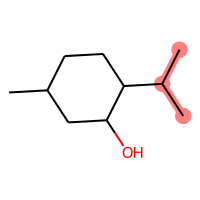

In [1]:
from opt_mol_pair_generator_double import SME_opt_sub_detect, sub_data_filter, sme_mol_opt
import pickle as pkl
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import re
import random

random.seed(2046)
def canonical_smi(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    Chem.SanitizeMol(mol)
    
    atoms_marked_zero = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomMapNum() == 0]
    cleaned_smiles = re.sub(r'\:\d+\]', ']', smiles)
    return cleaned_smiles, atoms_marked_zero


def mol_visualize(smi, remove_atom_index):
    mol = Chem.MolFromSmiles(smi)  # 例如，使用苯的SMILES字符串

    atoms_to_highlight = remove_atom_index

    bonds_to_highlight = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in atoms_to_highlight and bond.GetEndAtomIdx() in atoms_to_highlight:
            bonds_to_highlight.append(bond.GetIdx())

    drawer = rdMolDraw2D.MolDraw2DSVG(200, 200) 
    opts = drawer.drawOptions()

    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=atoms_to_highlight, highlightBonds=bonds_to_highlight)
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText().replace('svg:', '')
    display(SVG(svg))

    
model_name = 'ESOL'
# load model hyperparameter
with open('../result/hyperparameter_{}.pkl'.format(model_name), 'rb') as f:
    hyperparameter = pkl.load(f)
    
# since the mode is higher(to improve the logS), we will use SME to detected the most  
smi = 'CC1CCC(C(C)C)C(O)C1'
mode = 'higher'
sub_data = pd.read_csv('../prediction/summary/drugbank_ESOL_sub.csv')
pred, rm_sub_smi, sub_atom_num, rm_atom_idx, sub_to_change_value, sub_connect_num\
    = SME_opt_sub_detect(smiles=smi, model_name=model_name,
                         rgcn_hidden_feats=hyperparameter['rgcn_hidden_feats'],
                         ffn_hidden_feats=hyperparameter['ffn_hidden_feats'],
                         lr=hyperparameter['lr'], classification=hyperparameter['classification'], mode=mode)
print(pred, rm_sub_smi, sub_atom_num, rm_atom_idx, sub_to_change_value, sub_connect_num)
mol_visualize(smi, rm_atom_idx)

**2. Optimize the molecule through the substitution of substructures**<br />
After identifying the substructures that require optimization, the process involves searching for more hydrophilic substructures within a pre-constructed Drugbank substructure dataset(with attribution) to replace the identified hydrophobic substructures. In selecting the optimized substructures, we consider detailed information such as the number of atoms in the substructures. For a more detailed selection process, please refer to the article. As shown below, in this case, the isopropyl group is replaced with a fluorine atom (F) to increase the molecule's hydrophilicity.

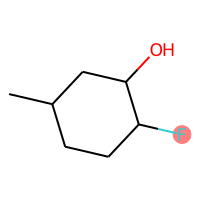

In [2]:
opt_sub_smi, opt_sub_smi_attri = sub_data_filter(sub_data, rm_sub_smi, sub_atom_num, sub_to_change_value, sub_connect_num, mode=mode)
origin_smi, _, sub_change, optimized_mol_smi = sme_mol_opt(smi, 0, rm_atom_idx, rm_sub_smi, opt_sub_smi, sub_num=1)
cleaned_smi, atom_idx = canonical_smi(optimized_mol_smi[0])
mol_visualize(cleaned_smi, atom_idx)

**3. Use the prediction model to validate optimized molecular pairs to ensure they meet our requirements**<br />
Using the ESOL model for prediction, it was observed that after optimization, the molecule's ESOL value improved from -2.637 to -0.962, indicating an enhancement in the molecule's hydrophilicity. This change, with a difference greater than 0.5, meets our predefined threshold for ESOL molecular optimization. Consequently, we have successfully constructed a pair of molecules optimized for ESOL.
![Image text](../figure/example1.svg)

**Repeat the aforementioned steps to generate new optimized molecular pairs**<br />
Using the optimized molecule as the starting point, we can repeat the aforementioned steps to generate new optimized molecular pairs. 

-0.9618239492177963 *C 1 [5] -0.3593772709369659 1


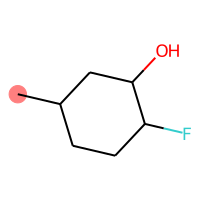

In [3]:
smi = cleaned_smi
pred, rm_sub_smi, sub_atom_num, rm_atom_idx, sub_to_change_value, sub_connect_num\
    = SME_opt_sub_detect(smiles=smi, model_name=model_name,
                         rgcn_hidden_feats=hyperparameter['rgcn_hidden_feats'],
                         ffn_hidden_feats=hyperparameter['ffn_hidden_feats'],
                         lr=hyperparameter['lr'], classification=hyperparameter['classification'], mode=mode)
print(pred, rm_sub_smi, sub_atom_num, rm_atom_idx, sub_to_change_value, sub_connect_num)
mol_visualize(smi, rm_atom_idx)

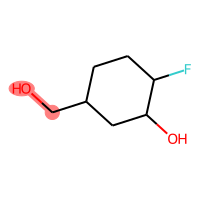

In [4]:
opt_sub_smi, opt_sub_smi_attri = sub_data_filter(sub_data, rm_sub_smi, sub_atom_num, sub_to_change_value, sub_connect_num, mode=mode)
origin_smi, _, sub_change, optimized_mol_smi = sme_mol_opt(smi, 0, rm_atom_idx, rm_sub_smi, opt_sub_smi, sub_num=1)
cleaned_smi, atom_idx = canonical_smi(optimized_mol_smi[0])
mol_visualize(cleaned_smi, atom_idx)

Clearly, we have obtained a new optimized molecular pair, as shown in the following figure.
![Image text](../figure/example2.svg)

Through the steps outlined above, we started with molecule 'CC1CCC(C(C)C)C(O)C1' and proceeded with continuous optimization. During this process, we obtained three optimized molecular pairs, where the transition from the initial molecule to the final molecule represents a multi-site optimized molecule pair.
![Image text](../figure/example3.svg)

Clearly, we can continue to repeat the process outlined above, selecting different models to construct molecular pairs optimized for multiple properties. By employing this iterative optimization approach, we have constructed a substantial number of optimized molecular pairs. These pairs have been compiled into our training dataset.